In [136]:
fname="trainingSubset0015.nc"
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

with nc.Dataset(fname) as f:
    sfcPrecip=f.variables['sfcPrecip'][:]
    stormTop=f.variables['stormTop'][:]
    dbzku_zero=f.variables['dbzku_zero'][:]
    dbzku_rain=f.variables['dbzku_rain'][:]
    dbzku_ice=f.variables['dbzku_ice'][:]
    dbzka_zero=f.variables['dbzka_zero'][:]
    hzero=f.variables['hzero'][:]
    pia=f.variables['pia'][:,:,:,0]
    pType=f.variables['pType'][:]
    sigmaZero=f.variables['sigmaZero'][:]
    landSurface=f.variables['landSurface'][:]
    elevation=f.variables['elevation'][:]
    localZenithAngle=f.variables['localZenithAngle'][:]
    zeta=f.variables['zeta'][:]
    PIAhybrid=f.variables['PIAhyb'][:]

In [137]:
print(PIAhybrid.shape)
a=np.nonzero(pType==0)  
print(PIAhybrid[:,:,:,0][a].max())
PIAhybrid[PIAhybrid<0]=0
print(zeta.max())

(87855, 16, 8, 2)
-9999.9
5.572902


17.615116
14.380118
12.671398
321 0
41.036846 -50.735973
(87822, 16, 8)
(87822, 16, 8, 2)
(87822, 16, 8, 2)


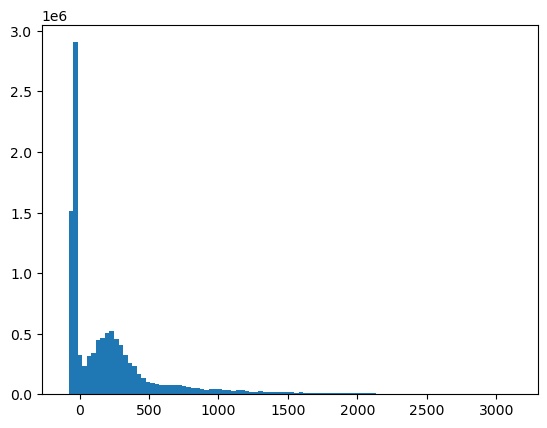

In [94]:
dbzku_rain[dbzku_rain<0]=0
dbzku_ice[dbzku_ice<0]=0
dbzku_zero[dbzku_zero<0]=0
dbzka_zero[dbzka_zero<0]=0
print(dbzku_rain.mean())
print(dbzku_ice.mean())
print(dbzku_zero.std())
print(landSurface.max(),landSurface.min())
#plt.hist(landSurface.flatten(),bins=100)
print(sigmaZero.max(),sigmaZero.min()) 
#hSZ=plt.hist(sigmaZero.flatten(),bins=100) 
hElv=plt.hist(elevation.flatten(),bins=100)
print(elevation.shape)
print(localZenithAngle.shape)
print(sigmaZero.shape)

In [138]:
print(stormTop.min())
stormTop[stormTop<0]=0
print(hzero.min())
print(pia.min())
print(sfcPrecip.min())
print(pType.min())

xL=np.stack([(dbzku_rain-12)/12,(dbzku_ice-12)/12,(dbzku_zero-12),(dbzka_zero-12),hzero/3e3,np.log10(1+pia/0.1),(stormTop-3000)/1e3],axis=-1)
xL=np.stack([(dbzku_rain-12)/12,(dbzku_ice-12)/12,(dbzku_zero-12),hzero/3e3,(stormTop-3000)/1e3,landSurface/100.,elevation/1000,sigmaZero[:,:,:,0]/20.0,localZenithAngle[:,:,:,0]/17,zeta[:,:,:]],axis=-1)

-9999.9
1381.6394
-0.0
0.0
0


In [139]:
print(xL.shape)
xL_scaled=np.swapaxes(xL,-2,-1)
xL_scaled=np.swapaxes(xL_scaled,-2,-3)
print(xL_scaled.shape)
yL_scaled=np.log10(1+PIAhybrid[:,:,:,0]/0.1)
yL_scaled=yL_scaled[:,np.newaxis,:,:]
print(yL_scaled.shape)

(87855, 16, 8, 10)
(87855, 10, 16, 8)
(87855, 1, 16, 8)


In [140]:
from neuralop.models import FNO

model_noKa = FNO(n_modes=(8, 8), hidden_channels=32,
                in_channels=10, out_channels=1)

In [141]:
from sklearn.model_selection import train_test_split
nt=xL_scaled.shape[0]
ntrain=int(0.8*nt)
x_train=xL_scaled[:ntrain]
x_test=xL_scaled[ntrain:]
y_train=yL_scaled[:ntrain]
y_test=yL_scaled[ntrain:]
#x_train, x_test, y_train, y_test = train_test_split(xL_scaled, yL_scaled, test_size=0.2, random_state=42)


In [142]:
from torch.utils.data import Dataset, DataLoader
import torch
class CustomDataset(Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = torch.tensor(x_train, dtype=torch.float32)
        self.y_train = torch.tensor(y_train, dtype=torch.float32)
        self.transform = transform

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        sample = self.x_train[idx], self.y_train[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

# Define any transformations if necessary
# Example of transformation
# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

# Create custom dataset
# Pass transform if any
# train_dataset = CustomDataset(x_train, y_train, transform=transform)
train_dataset = CustomDataset(x_train, y_train)

# Define DataLoader
batch_size = 64
shuffle = True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

In [143]:
#train the model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

model=model_noKa

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [155]:

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, labels)  # Assuming images are flattened to 1D
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print('Finished Training')

Epoch [1/5], Loss: 0.0218
Epoch [2/5], Loss: 0.0231
Epoch [3/5], Loss: 0.0212
Epoch [4/5], Loss: 0.0203
Epoch [5/5], Loss: 0.0190
Finished Training


In [156]:
y_pred=model(torch.tensor(x_test, dtype=torch.float32))

In [157]:
mse=criterion(y_pred,torch.tensor(y_test, dtype=torch.float32))
print(mse)
print(np.corrcoef(y_pred.detach().numpy().flatten(),y_test.flatten()))
print(y_pred.shape)
# save full model
torch.save(model, "sigmaZeroModel_15iterations_zeta_PIA.pt")

tensor(0.0199, grad_fn=<MseLossBackward0>)
[[1.         0.95413818]
 [0.95413818 1.        ]]
torch.Size([17571, 1, 16, 8])


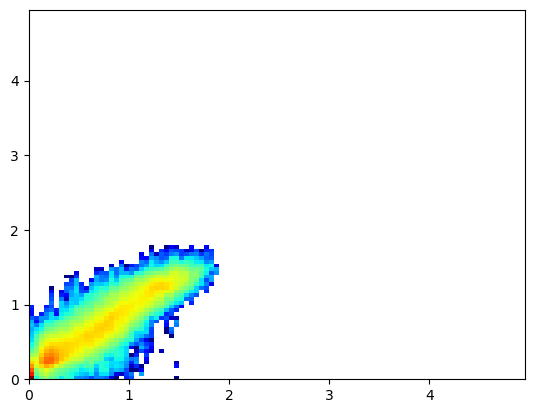

In [158]:
y_pred_np=y_pred.detach().numpy()
import matplotlib 
h2d=plt.hist2d(y_test[:,0,4:-4,:].flatten(),y_pred_np[:,0,4:-4,:].flatten(),bins=np.arange(100)*0.05,norm=matplotlib.colors.LogNorm(),cmap='jet')


[[1.         0.89399927]
 [0.89399927 1.        ]]
0.4314922 0.4723881


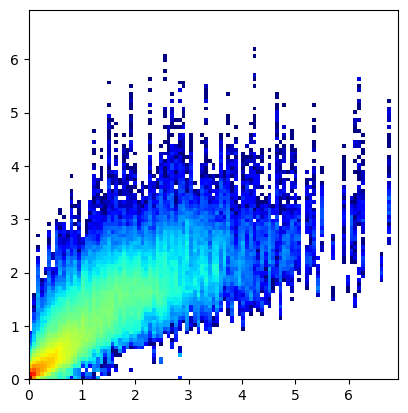

In [159]:
sfcRain_pred=0.1*(10**(y_pred_np)[:,0,4:-4,:]-1)
sfcRain_test=0.1*(10**(y_test)[:,0,4:-4,:]-1)
print(np.corrcoef(sfcRain_pred.flatten(),sfcRain_test.flatten()))
ax=plt.figure()
h2d_rain=plt.hist2d(sfcRain_test.flatten(),sfcRain_pred.flatten(),bins=np.arange(100)*0.07,norm=matplotlib.colors.LogNorm(),cmap='jet')
#set aspect ratio to be equal
ax.gca().set_aspect('equal', adjustable='box')
#ax.set_aspect('equal')
print(sfcRain_pred.mean(),sfcRain_test.mean())

(array([1.35717e+06, 2.37643e+05, 8.70780e+04, 3.67950e+04, 1.92320e+04,
        1.26960e+04, 1.02640e+04, 7.98000e+03, 4.07500e+03, 5.65300e+03,
        3.65600e+03, 3.73900e+03, 3.16700e+03, 3.54500e+03, 2.22600e+03,
        1.97800e+03, 2.40100e+03, 1.80600e+03, 7.90000e+02, 1.46600e+03,
        1.38700e+03, 1.10200e+03, 8.57000e+02, 5.92000e+02, 5.32000e+02,
        5.97000e+02, 8.97000e+02, 1.31000e+02, 3.36000e+02, 2.34000e+02,
        6.99000e+02, 1.86000e+02, 4.72000e+02, 3.50000e+01, 2.42000e+02,
        1.43000e+02, 3.43000e+02, 2.81000e+02, 3.40000e+02, 3.20000e+01,
        1.21000e+02, 1.80000e+02, 1.05000e+02, 4.80000e+01, 0.00000e+00,
        1.93000e+02, 9.90000e+01, 1.04000e+02, 6.40000e+01, 0.00000e+00,
        1.24000e+02, 1.80000e+02, 1.28000e+02, 1.07000e+02, 1.83000e+02,
        0.00000e+00, 0.00000e+00, 1.45000e+02, 6.40000e+01, 6.40000e+01,
        6.40000e+01, 1.05000e+02, 0.00000e+00, 1.14000e+02, 6.40000e+01,
        4.50000e+01, 5.40000e+01, 0.00000e+00, 4.40

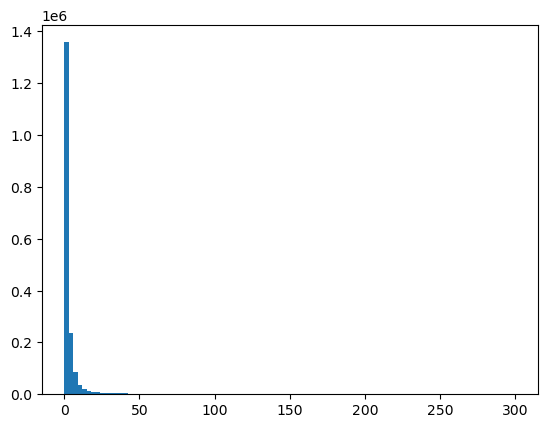

In [38]:
a=np.nonzero(sfcPrecip>0)
plt.hist(sfcPrecip[a], bins=100)